# Module

In [ ]:
# pip install bm3d
# pip install scikit-image
# pip install opencv-python
# pip install scikit-learn
# pip install regex
# pip install imagecodecs

In [1]:
#Image Processing
import cv2
from skimage.util import img_as_ubyte
from skimage import io, img_as_float
from skimage.filters import median
from skimage.morphology import disk
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio
import bm3d
from skimage.filters import unsharp_mask
from skimage import data
from skimage.filters import threshold_multiotsu

#General
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import regex
import pandas as pd
import numpy as np
from scipy import stats as st
import re
import regex

#ML Algorithm
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

# 1. Image Conditioning

In [2]:
path_dataset = 'dataset2/'

## Originale Saving

In [3]:
#ORIGINAL IMAGE
def originale(path_dataset):
    all_separations = {}
    tik = 0
    for name in os.listdir(path_dataset + '/bse/'):
        sep_dict = {'bse': [], 'cl': [], 'mm': []}
        path_bse = os.path.join(path_dataset + '/bse/', name)
        path_cl = path_dataset + '/cl/' + name
        path_mm = path_dataset + '/mm/' + name

        sep_dict['bse'] = cv2.imread(path_bse)
        sep_dict['cl'] = cv2.imread(path_cl)

        k= str(cv2.imread(path_mm))

        if k != "None":
            sep_dict['mm'] = cv2.imread(path_mm)
        else:
            tik = 1
            path_mm = re.sub(r'\Wtif', '_colour.tif', path_mm)
            sep_dict['mm'] = cv2.imread(path_mm)

        all_separations[name] = sep_dict

        del sep_dict

    return all_separations, tik

def original_flip(path_dataset):
    tik = original[1]
    for name in os.listdir(path_dataset + '/bse/'):
        try:
            bse = original[0][name]['bse']
            path_bse = os.path.join(path_dataset + '/bse/', name)
            cv2.imwrite(path_bse, bse)

            cl = original[0][name]['cl']
            path_cl = path_dataset + '/cl/' + name
            cv2.imwrite(path_cl, cl)

            mm = original[0][name]['mm']
            if tik == 0:
                path_mm = path_dataset + '/mm/' + name
            else:

                namea = re.sub(r'\Wtif', '_colour.tif', name)
                path_mm = path_dataset + '/mm/' + namea
            cv2.imwrite(path_mm, mm)
        except:
            pass

In [4]:
original = originale(path_dataset)

## CL De-Noising (BM3D - Unsharpen Mask)

In [5]:
def cl_denoising_all(path_dataset):
    IMAGE_PATH_CL = path_dataset+'/cl/'
    for name in os.listdir(IMAGE_PATH_CL):
        im2 = img_as_float(io.imread(IMAGE_PATH_CL + name, as_gray=True))
        
        #Apply BM3D
        im2_denoised = bm3d.bm3d(im2, sigma_psd=0.5, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
        
        #Apply unsharpen
        im2_denoised = unsharp_mask(im2_denoised, radius=1, amount=1)
        cv_image = img_as_ubyte(im2_denoised)
        
        cv2.imwrite(IMAGE_PATH_CL + name, cv_image)

In [6]:
cl_denoising_all(path_dataset)

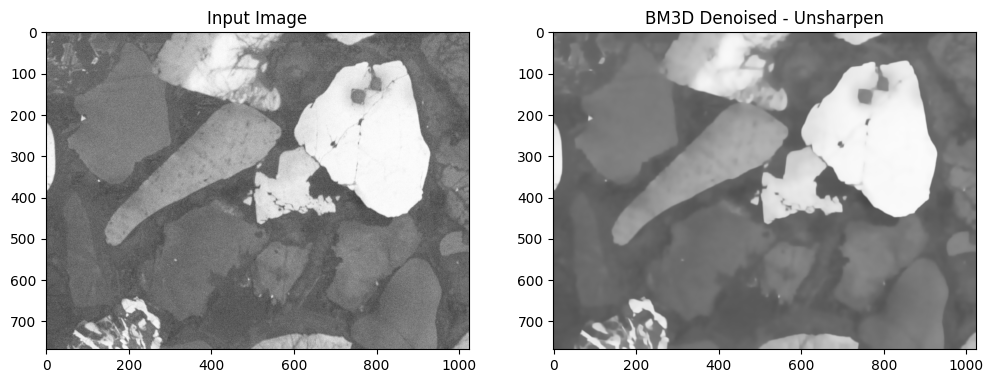

In [7]:
#Test BM3D
filename = 'dataset2_support/cl/image0_0.tif'

img = cv2.imread(filename)
noisy_img = img_as_float(img)
BM3D_denoised_image = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(noisy_img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(BM3D_denoised_image, cmap='gray')
ax2.title.set_text('BM3D Denoised - Unsharpen')

plt.show()

## BSE Conditioning (Contrast - Brightness - Median Blur)

In [8]:
def con_bri_single(img, contrast, brightness):
    img = np.int16(img)
    img = img * (contrast/127+1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    return img

In [9]:
#Clear all image BSE
def bse_con_bri_all(path_datset):
    IMAGE_PATH_BSE = path_dataset+'/bse/'
    path_bse = IMAGE_PATH_BSE
    for name in os.listdir(path_bse): 
        img = cv2.imread(os.path.join(path_bse,name),0)

        counts, bins, bars = plt.hist(img.flat , bins=25, range=(0,255))
        dic_hist = {i:counts[i] for i,j in enumerate(bars)}
        plt.close()

        if dic_hist[0] < 10:
            img_adj = con_bri_single(img, 160, -100)
            cv2.imwrite(os.path.join(path_bse,name), img_adj)

        else:
            print(str(name) + ' is good') 

In [10]:
bse_con_bri_all(path_dataset)

image0_0.tif is good
image0_1.tif is good
image0_2.tif is good
image14_1.tif is good


In [11]:
#Test ConBri
filename = 'dataset2_support/bse/image5_58_3.tif'

img = cv2.imread(filename)
noisy_img = img_as_float(img)
conbri = con_bri_single(img, 160, -100)


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(noisy_img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(conbri, cmap='gray')
ax2.title.set_text('BSE_Contrast-Brightness')

plt.show()

In [12]:
def bse_denoising_all(path_dataset):
    IMAGE_PATH_BSE = path_dataset+'/bse/'
    for name in os.listdir(IMAGE_PATH_BSE):
        im2 = img_as_float(io.imread(IMAGE_PATH_BSE + name, as_gray=True))
        
        #Median Blur
        cv_image= cv2.medianBlur(img_as_ubyte(im2), 3)
        
        cv2.imwrite(IMAGE_PATH_BSE + name, cv_image)

In [13]:
#Test Median Blur
filename = 'dataset2_support/bse/image0_0.tif'

img = cv2.imread(filename)
noisy_img = img_as_float(img)
medblur = cv2.medianBlur(img, 3)


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(noisy_img, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(medblur, cmap='gray')
ax2.title.set_text('Median Blur')

plt.show()

In [14]:
bse_denoising_all(path_dataset)

# 2. Image Processing

## BSE K-Means: Separating Quartz, Minerals, & Pores

In [15]:
def mineral_code(cv2_img):
    #Change to RGB
    cv2_rgb = cv2.cvtColor(cv2_img,cv2.COLOR_BGR2RGB)
    
    #Define Mineral Collection based on RGB
    det_col = []
    for i in cv2_rgb:
        for j in i:
            det_col.append(j)
    
    col_code = set([tuple(x) for x in set(tuple(z) for z in det_col) for det_col in j])
    
    return col_code

In [16]:
def simple_single_kmeans(n_clusters, X_im, input_bse_gray):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_im)
    segmented_img = (kmeans.cluster_centers_[kmeans.labels_]).astype(int)
    
    return segmented_img.reshape(input_bse_gray.shape)

In [17]:
def kmean_single(bse_path):
    #K-Means in BSE
    filename = bse_path
    input_bse = cv2.imread(filename)
    input_bse_gray = cv2.cvtColor(input_bse,cv2.COLOR_BGR2HSV)[:,:,2]
    X_im= input_bse_gray.reshape(-1, 1)


    segmented_imgs_2 = []

    n_colors = (1,2,3,4,5)
    for n_clusters in n_colors:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_im)
        segmented_img = (kmeans.cluster_centers_[kmeans.labels_]).astype(int)
        segmented_imgs_2.append(segmented_img.reshape(input_bse_gray.shape))

    fig8 = plt.figure(figsize = (20,20))

    plt.subplot(321)
    plt.imshow(input_bse_gray, cmap='gray')
    plt.title("Original image bse")
    plt.axis('off')

    for idx, n_clusters in enumerate(n_colors):
        plt.subplot(322 + idx)
        plt.imshow(segmented_imgs_2[idx], cmap='gray')
        plt.title("{} colors: {}".format(n_clusters, str(set(sum(segmented_imgs_2[idx].tolist(),[])))))
        plt.axis('off')

    plt.show()
    
    return segmented_imgs_2

dd = kmean_single('dataset2/bse/image0_0.tif')

In [18]:
#K-Means in BSE
def bse_kmeans_all(path_dataset):
    IMAGE_PATH_BSE = path_dataset + '/bse/'
    IMAGE_PATH_MM = path_dataset + '/mm/'

    # Preparation
    all_separations = {}

    # Run All
    for name in os.listdir(IMAGE_PATH_BSE):

        # Preparation
        dict_separation = {'seg_por': [], 'view_por': [], 'arr_por': [],
                           'seg_qtz': [], 'view_qtz': [], 'arr_qtz': [],
                           'seg_mine': [], 'view_mine': [], 'arr_mine': []}

        bse_path = os.path.join(IMAGE_PATH_BSE, name)
        mm_path = os.path.join(IMAGE_PATH_MM, name)

        input_bse = cv2.imread(bse_path)

        # Check mineral
        k = str(cv2.imread(mm_path))

        if k != "None":
            input_mm = cv2.imread(mm_path)
            mineral_col = mineral_code(input_mm)
        else:
            mm_path = re.sub(r'\Wtif', '_colour.tif', mm_path)
            input_mm = cv2.imread(mm_path)
            mineral_col = mineral_code(input_mm)

        # Threshold Key
        flat_bse = input_bse.flatten()
        val_por_bse = np.min(flat_bse)
        val_qtz_bse = st.mode(np.delete(flat_bse, np.where(flat_bse == val_por_bse)))[0][0]

        # There is an indication of other mineral with lighter colour than Quartz
        if input_bse.flatten().max() > val_qtz_bse:
            input_bse_gray = cv2.cvtColor(input_bse, cv2.COLOR_BGR2HSV)[:, :, 2]

            # Preperation for K-Means
            X_im = input_bse_gray.reshape(-1, 1)
            n_clus = 4

            # Deploy k-means
            segmented_imgs = simple_single_kmeans(n_clus, X_im, input_bse_gray)
            val_seg = np.array(list(set(sum(segmented_imgs.tolist(), []))))

            # Deploy k-means again if mineral still couldn't defined
            while len(np.where(val_seg >= val_qtz_bse)[0].tolist()) == 0:
                n_clus = n_clus + 1
                segmented_imgs = simple_single_kmeans(n_clus, X_im, input_bse_gray)
                val_seg = np.array(list(set(sum(segmented_imgs.tolist(), []))))


        # There is maybe other mineral with darker colour than Quartz (Quartz is the Brightest)
        else:
            input_bse_gray = cv2.cvtColor(input_bse, cv2.COLOR_BGR2HSV)[:, :, 2]

            # Preperation for K-Means
            X_im = input_bse_gray.reshape(-1, 1)
            n_clus = 3

            # Deploy k-means = 3
            segmented_imgs = simple_single_kmeans(n_clus, X_im, input_bse_gray)
            val_seg = np.array(list(set(sum(segmented_imgs.tolist(), []))))

        # Define the Segmentation
        # Grab The Porous Segment
        val_por = np.min(val_seg)
        segmented_por = segmented_imgs == val_por
        segmented_por = segmented_por.astype(int)
        dict_separation['seg_por'].append(segmented_por)

        view_segmented_por = segmented_por * 255
        dict_separation['view_por'].append(view_segmented_por)

        array_segmented_por = cv2.merge([segmented_por, segmented_por, segmented_por])
        dict_separation['arr_por'].append(array_segmented_por)

        # Grab the Quartz mineral Segment
        flat_seg = segmented_imgs.flatten()
        val_qtz = st.mode(np.delete(flat_seg, np.where(flat_seg == val_por)))[0][0]
        segmented_qtz = segmented_imgs == val_qtz
        segmented_qtz = segmented_qtz.astype(int)
        dict_separation['seg_qtz'].append(segmented_qtz)

        view_segmented_qtz = segmented_qtz * 255
        dict_separation['view_qtz'].append(view_segmented_qtz)

        array_segmented_qtz = cv2.merge([segmented_qtz, segmented_qtz, segmented_qtz])
        dict_separation['arr_qtz'].append(array_segmented_qtz)

        # Grab The Minerals Segment
        val_mine = np.max(val_seg)
        segmented_mine = (segmented_imgs != val_por) & (segmented_imgs != val_qtz)
        segmented_mine = segmented_mine.astype(int)
        dict_separation['seg_mine'].append(segmented_mine)

        view_segmented_mine = segmented_mine * 255
        dict_separation['view_mine'].append(view_segmented_mine)

        array_segmented_mine = cv2.merge([segmented_mine, segmented_mine, segmented_mine])
        dict_separation['arr_mine'].append(array_segmented_mine)

        # Add to the list
        all_separations[name] = dict_separation

        # Reset the dict
        del dict_separation

    return all_separations

In [19]:
all_results_separation = bse_kmeans_all(path_dataset)

C:\Users\Ryan Bobby A\AppData\Local\Temp\ipykernel_13148\2577873795.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  val_qtz_bse = st.mode(np.delete(flat_bse, np.where(flat_bse == val_por_bse)))[0][0]
C:\Users\Ryan Bobby A\AppData\Local\Temp\ipykernel_13148\2577873795.py:84: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accep

In [20]:
plt.imshow(all_results_separation['image0_0.tif']['view_qtz'][0], cmap='gray')

## Image Alignment

In [21]:
def cl_pores_extraction_single(im2, n):
   
    #Convert it to HSV & preparation for Multiple Otsu
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2HSV)[:,:,2]
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(1,1))
    im2_gray_ski = clahe.apply(im2_gray)

    #Multiple Otsu
    tre = threshold_multiotsu(im2_gray_ski, classes=n)
    regions = np.digitize(im2_gray_ski, bins = tre)
    output = img_as_ubyte(regions)
    cl_otsu = output * 255
    
    return cl_otsu

In [22]:
#Single Registration
def registration_single(IMAGE_PATH_BSE, IMAGE_PATH_CL, id_img, view_segmented_pore):
    #Warning
    remark = []
    
    # Read the images to be aligned
    im1 =  cv2.imread(IMAGE_PATH_BSE)
    im2 =  cv2.imread(IMAGE_PATH_CL)

    # Masked Image from cl_otsu and view segmented pore for TransfromEEC
    im1_gray = view_segmented_pore.astype('uint8')
    im2_gray = cl_pores_extraction_single(im2, 2)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 10000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-100;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    try:
        try:
            (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
            remark.append(id_img + ' is good')
        except:
            im2_gray = cl_pores_extraction_single(im2, 3)
            im2_gray = 255 - im2_gray
            (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
            remark.append(id_img + ' is good in Inverted Color')
    except:
        remark.append(id_img + 'Not Able to Perform good result')

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

    return im1, im2, im2_aligned, warp_matrix, remark

In [23]:
def registration_all(path_dataset):
    
    #Preparation
    all_subseter = {}
    
    for name in os.listdir(path_dataset+'/bse/'):
        
        dict_subseter = {'x_min':[], 'x_max':[],
                         'y_min':[], 'y_max':[]}
        
        view_segmented_pore = all_results_separation[name]['view_por'][0]
        
        path_bse = os.path.join(path_dataset+'/bse/',name)
        path_cl = path_dataset + '/cl/'+ name
        path_mm = path_dataset + '/mm/' + name
        
        #Apply alignment & Cut the unused area
        #Registration
        im1, im2, im2_aligned, warp_matrix, remark = registration_single(path_bse, path_cl, name, view_segmented_pore )
        
        #Search for the color black
        mask = cv2.inRange(im2_aligned, np.array([0,0,0]), np.array([0,0,0]))
        mask2 = np.equal(mask, 0)
        overlap_pix = np.argwhere(mask2==True)
        
        #Array Slicing
        ymin, xmin = int(overlap_pix[:,0].min()), int(overlap_pix[:,1].min())
        ymax, xmax = int(overlap_pix[:,0].max()), int(overlap_pix[:,1].max())
        
        print(remark)
        
        #Save stacked bse - cl with sliced area
        image = cv2.add(im2_aligned[ymin:ymax+1,xmin:xmax+1], im1[ymin:ymax+1,xmin:xmax+1])
        cv2.imwrite(path_dataset + 'cl_segmented/' + name , image)
        
        #Show the result
        plt.imshow(image)
        plt.show()
        
        #Saved Sliced mm
        try:
            mm = cv2.imread(path_mm)
            cv2.imwrite(path_mm, mm[ymin:ymax+1,xmin:xmax+1])
        except:
            path_mm = re.sub(r'\Wtif','_colour.tif',path_mm)
            mm = cv2.imread(path_mm)
            cv2.imwrite(path_mm, mm[ymin:ymax+1,xmin:xmax+1])
        
        #Save Sliced bse
        bse = cv2.imread(path_bse)
        cv2.imwrite(path_bse, bse[ymin:ymax+1,xmin:xmax+1])
        
        #Save Sliced cl
        cv2.imwrite(path_cl, im2_aligned[ymin:ymax+1,xmin:xmax+1])
        
        #Record all subseter
        dict_subseter['x_min'] = xmin
        dict_subseter['y_min'] = ymin 
        dict_subseter['x_max'] = xmax 
        dict_subseter['y_max'] = ymax
        
        #Record in all
        all_subseter[name] = dict_subseter
        
        #Delete
        del dict_subseter
        
    return all_subseter

C:\Users\Ryan Bobby A\anaconda3\envs\trial2\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)
C:\Users\Ryan Bobby A\anaconda3\envs\trial2\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return _convert(image, np.uint8, force_copy)


['image0_0.tif is good in Inverted Color']


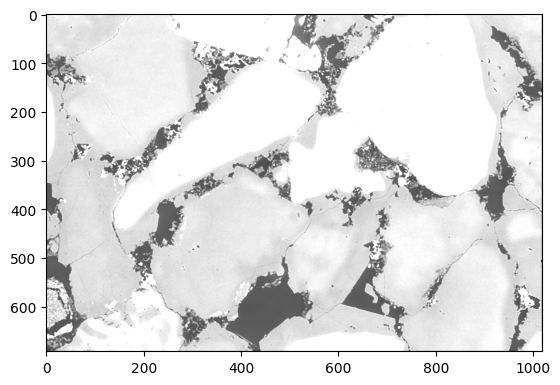

['image0_1.tif is good in Inverted Color']


['image0_2.tif is good in Inverted Color']


['image14_1.tif is good in Inverted Color']


['image5_58_3.tif is good in Inverted Color']


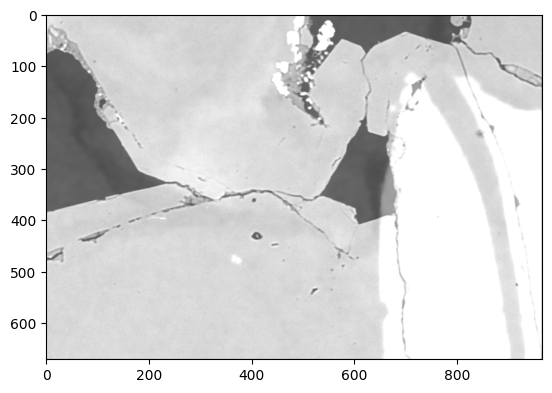

In [24]:
all_results_subseters = registration_all(path_dataset)

# CL K-Means: Separating Quartz & Overgrowth Quartz

In [25]:
def kmean_single(bse_path):
    #K-Means in BSE
    filename = bse_path
    input_bse = cv2.imread(filename)
    input_bse_gray = cv2.cvtColor(input_bse,cv2.COLOR_BGR2HSV)[:,:,2]
    X_im= input_bse_gray.reshape(-1, 1)


    segmented_imgs_2 = []

    n_colors = (1,2,3,4,5)
    for n_clusters in n_colors:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_im)
        segmented_img = (kmeans.cluster_centers_[kmeans.labels_]).astype(int)
        segmented_imgs_2.append(segmented_img.reshape(input_bse_gray.shape))

    fig8 = plt.figure(figsize = (20,20))

    plt.subplot(321)
    plt.imshow(input_bse_gray, cmap='gray')
    plt.title("Original image bse")
    plt.axis('off')

    for idx, n_clusters in enumerate(n_colors):
        plt.subplot(322 + idx)
        plt.imshow(segmented_imgs_2[idx], cmap='gray')
        plt.title("{} colors: {}".format(n_clusters, str(set(sum(segmented_imgs_2[idx].tolist(),[])))))
        plt.axis('off')

    plt.show()
    
    return segmented_imgs_2

In [26]:
def kmean_single_image(bse_path):
    #K-Means in BSE
    input_bse = bse_path
    input_bse_gray = only_qtz
    X_im= input_bse_gray.reshape(-1, 1)


    segmented_imgs_2 = []

    n_colors = (3,4,5,6,10)
    for n_clusters in n_colors:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_im)
        segmented_img = (kmeans.cluster_centers_[kmeans.labels_]).astype(int)
        segmented_imgs_2.append(segmented_img.reshape(input_bse_gray.shape))

    fig8 = plt.figure(figsize = (20,20))

    plt.subplot(321)
    plt.imshow(input_bse_gray, cmap='gray')
    plt.title("Original image bse")
    plt.axis('off')

    for idx, n_clusters in enumerate(n_colors):
        plt.subplot(322 + idx)
        plt.imshow(segmented_imgs_2[idx], cmap='gray')
        plt.title("{} colors: {}".format(n_clusters, str(set(sum(segmented_imgs_2[idx].tolist(),[])))))
        plt.axis('off')

    plt.show()
    
    return segmented_imgs_2

In [27]:
#Subseter
name = 'image0_0.tif'
xmin = all_results_subseters[name]['x_min']
ymin = all_results_subseters[name]['y_min']
xmax = all_results_subseters[name]['x_max']
ymax = all_results_subseters[name]['y_max']

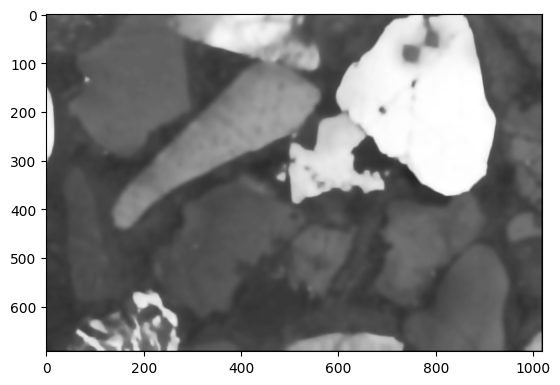

In [28]:
filename = 'dataset2/cl/image0_0.tif'
img = cv2.imread(filename,0)

plt.imshow(img, cmap='gray')

In [31]:
#K-Means in CL
def cl_kmeans_all(path_dataset):
    IMAGE_PATH_CL = path_dataset+'/cl/'
    
    #Preparation
    all_separations = {}
    
    #Run All
    for name in os.listdir(IMAGE_PATH_CL):
        
        #Subseter
        xmin = all_results_subseters[name]['x_min']
        ymin = all_results_subseters[name]['y_min']
        xmax = all_results_subseters[name]['x_max']
        ymax = all_results_subseters[name]['y_max']

        #Preparation
        dict_separation = {'seg_ovg':[], 'view_ovg':[], 'arr_ovg':[], 
               'seg_qtz_only':[], 'view_qtz_only':[], 'arr_qtz_only':[]}

        #Read the data
        cl_path = os.path.join(IMAGE_PATH_CL,name)
        input_cl = cv2.imread(cl_path,0)

        #CL - Conditioning
        clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(1,1))
        cla_im = clahe.apply(input_cl)

        #Only deal with Quartz in CL
        only_qtz = all_results_separation[name]['seg_qtz'][0][ymin:ymax+1,xmin:xmax+1] * cla_im

        #Preperation for K-Means in CL
        X_im= only_qtz.reshape(-1, 1)
        n_clus = 6

        #Deploy k-means
        segmented_imgs = simple_single_kmeans(n_clus, X_im, only_qtz)
        val_seg = np.array(list(set(sum(segmented_imgs.tolist(),[]))))

        #Define the Segmentation
        #Grab The Porous Segment
        val_por = np.min(val_seg)
        segmented_por = segmented_imgs == val_por
        segmented_por = segmented_por.astype(int)
        
        #Grab the OverGrowth Quartz mineral Segment
        val_ovg = np.sort(val_seg)[1]
        segmented_ovg = segmented_imgs == val_ovg
        segmented_ovg = segmented_ovg.astype(int)
        dict_separation['seg_ovg'].append(segmented_ovg)

        view_segmented_ovg = segmented_ovg * 255
        dict_separation['view_ovg'].append(view_segmented_ovg)

        array_segmented_ovg = cv2.merge([segmented_ovg,segmented_ovg,segmented_ovg])
        dict_separation['arr_ovg'].append(array_segmented_ovg)

        
        #Grab The Quartz only
        #Grab other
        segmented_used = segmented_ovg + segmented_por
        segmented_qtz_only = ~segmented_used + 2
        
        segmented_qtz_only = segmented_qtz_only != 0
        segmented_qtz_only = segmented_qtz_only.astype(int)
        dict_separation['seg_qtz_only'].append(segmented_qtz_only)
        
        view_segmented_qtz_only = segmented_qtz_only * 255
        dict_separation['view_qtz_only'].append(view_segmented_qtz_only)

        array_segmented_qtz_only = cv2.merge([segmented_qtz_only,segmented_qtz_only,segmented_qtz_only])
        dict_separation['arr_qtz_only'].append(array_segmented_qtz_only)
        
        
        #Add to the list
        all_separations[name] = dict_separation
        
        #Reset the dict
        del dict_separation
        
    return all_separations

In [32]:
all_results_separation_qtz = cl_kmeans_all(path_dataset)

In [33]:
tes_ovg = all_results_separation_qtz['image0_0.tif']['view_ovg'][0]
tes_qtz = all_results_separation_qtz['image0_0.tif']['view_qtz_only'][0]

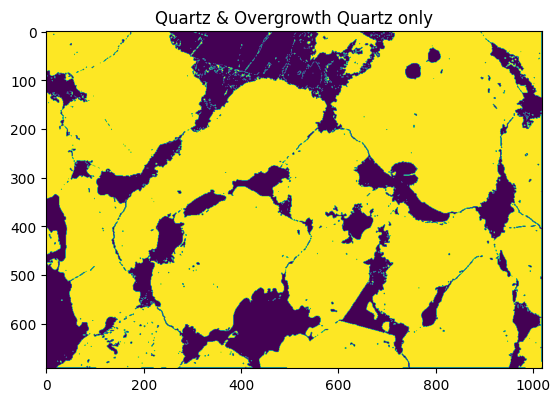

In [35]:
plt.title('Quartz & Overgrowth Quartz only')
plt.imshow(tes_ovg + tes_qtz)

# KDTree Minerals: Separating Feldspar, Overgrowth Feldspar, Other Minerals

In [36]:
all_results_subseters

{'image0_0.tif': {'x_min': 0, 'x_max': 1018, 'y_min': 0, 'y_max': 691},
 'image0_1.tif': {'x_min': 0, 'x_max': 1015, 'y_min': 0, 'y_max': 688},
 'image0_2.tif': {'x_min': 0, 'x_max': 1009, 'y_min': 0, 'y_max': 690},
 'image14_1.tif': {'x_min': 0, 'x_max': 1011, 'y_min': 0, 'y_max': 692},
 'image5_58_3.tif': {'x_min': 0, 'x_max': 965, 'y_min': 0, 'y_max': 670}}

In [37]:
def ktree_mine(path_dataset):
    # Preparation
    dict_ktree_mine_all = {}
    dict_ktree_mine_seg = {}

    for name in os.listdir(path_dataset + '/bse/'):

        # Preparation
        dict_separation = {'seg_ovg_feld': [], 'view_ovg_feld': [], 'arr_ovg_feld': [],
                           'seg_feld': [], 'view_feld': [], 'arr_feld': [],
                           'seg_other': [], 'view_other': [], 'arr_other': []}

        # Subseter
        xmin = all_results_subseters[name]['x_min']
        ymin = all_results_subseters[name]['y_min']
        xmax = all_results_subseters[name]['x_max']
        ymax = all_results_subseters[name]['y_max']

        # Define the features
        input_bse_mine = all_results_separation[name]['arr_mine'][0][ymin:ymax + 1, xmin:xmax + 1]

        # Define MM
        path_mm = path_dataset + '/mm/' + name
        k = str(cv2.imread(path_mm))

        if k != "None":
            input_mm = cv2.imread(path_mm)
            input_mm = cv2.cvtColor(input_mm, cv2.COLOR_BGR2RGB)

        else:
            path_mm = re.sub(r'\Wtif', '_colour.tif', path_mm)
            input_mm = cv2.imread(path_mm)
            input_mm = cv2.cvtColor(input_mm, cv2.COLOR_BGR2RGB)

        coba = input_bse_mine * input_mm

        try:
            mineral_col = mineral_code(cv2.cvtColor(input_mm, cv2.COLOR_RGB2BGR))

            col_pos = {'x': [], 'y': [], 'color': []}
            for i in mineral_col:
                if i != (0, 0, 0):
                    Y, X = np.where(np.all(coba == list(i), axis=2))
                    zipped = np.column_stack((X, Y)).tolist()
                    for j in zipped:
                        col_pos['x'].append(j[0])
                        col_pos['y'].append(j[1])
                        col_pos['color'].append(i)
                else:
                    pass

            df = pd.DataFrame(col_pos)

            if (df.color == (243, 232, 90)).any() == True:
                df_mineral = df[df['color'] != tuple([243, 232, 90])].reset_index(drop=True)
                df_qtz = df[df['color'] == tuple([243, 232, 90])].reset_index(drop=True)

                # KDTree Adjustment
                np.random.seed(0)
                X = df_qtz[['x', 'y']].to_numpy()
                Y = df_mineral[['x', 'y']].to_numpy()
                tree = KDTree(Y, leaf_size=2)
                dist, ind = tree.query(X, k=1)

                df_qtz = pd.DataFrame(X, columns=['x', 'y'])
                df_qtz['color'] = ind
                df_qtz['dist'] = dist
                df_qtz['color'] = df_qtz['color'].apply(lambda x: df_mineral['color'].iloc[x])

                loc = np.array([df_qtz.x, df_qtz.y]).T
                for i, j in enumerate(loc.tolist()):
                    coba[j[1], j[0]] = df_qtz['color'].iloc[i]

            else:
                pass

        except:
            pass

        ciba = np.copy(coba)

        # Grab Feldspar Overgrowth #40ffff
        segmented_ovg_feld = np.all(ciba == [64, 255, 255], axis=2)
        segmented_ovg_feld = segmented_ovg_feld.astype(int)
        dict_separation['seg_ovg_feld'].append(segmented_ovg_feld)

        view_segmented_ovg_feld = segmented_ovg_feld * 255
        dict_separation['view_ovg_feld'].append(view_segmented_ovg_feld)

        array_segmented_ovg_feld = cv2.merge([segmented_ovg_feld, segmented_ovg_feld, segmented_ovg_feld])
        dict_separation['arr_ovg_feld'].append(array_segmented_ovg_feld)

        # Grab Feldspar (Purple color) #b026c4
        segmented_feld = np.all(ciba == [176, 38, 196], axis=2)
        segmented_feld = segmented_feld.astype(int)
        dict_separation['seg_feld'].append(segmented_feld)

        view_segmented_feld = segmented_feld * 255
        dict_separation['view_feld'].append(view_segmented_feld)

        array_segmented_feld = cv2.merge([segmented_feld, segmented_feld, segmented_feld])
        dict_separation['arr_feld'].append(array_segmented_feld)

        # Grab non_mineral
        segmented_nonmin = np.all(ciba == [0, 0, 0], axis=2)
        segmented_nonmin = segmented_nonmin.astype(int)

        # Grab other
        segmented_used = segmented_feld + segmented_ovg_feld + segmented_nonmin
        segmented_other = ~segmented_used + 2

        segmented_other = segmented_other != 0
        segmented_other = segmented_other.astype(int)

        segmented_other = segmented_other.astype(int)
        dict_separation['seg_other'].append(segmented_other)

        view_segmented_other = segmented_other * 255
        dict_separation['view_other'].append(view_segmented_other)

        array_segmented_other = cv2.merge([segmented_other, segmented_other, segmented_other])
        dict_separation['arr_other'].append(array_segmented_other)

        # Add to the big dictionary
        dict_ktree_mine_seg[name] = dict_separation

        # Reset the dict
        del dict_separation

        # Big Dictionary for no separation
        dict_ktree_mine_all[name] = ciba

    return dict_ktree_mine_all, dict_ktree_mine_seg

In [38]:
all_results_ktree_mine, seg_results_ktree_mine = ktree_mine(path_dataset)

In [41]:
all_results_ktree_mine

{'image0_0.tif': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=int32),
 'image0_1.tif': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
    

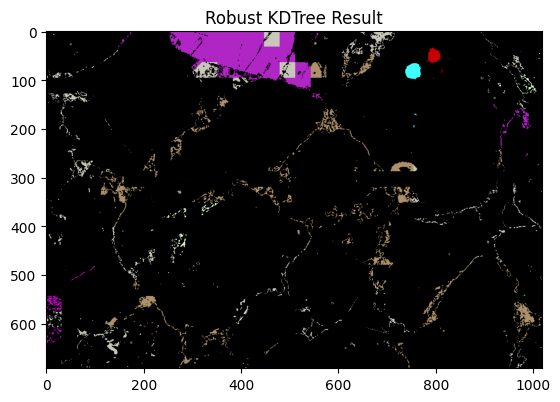

In [47]:
plt.title('Robust KDTree Result')
plt.imshow(all_results_ktree_mine['image0_0.tif'])

# Calculation

In [55]:
def calculation(path_dataset):
    #Preparation
    calculation_case_1= {'path': [],
                    'quartz_rel_area':[],
                    'overgrowth_rel_area' :[],
                    'otherminerals_rel_area':[],
                    'pores_rel_area' : []}
    
    calculation_case_2= {'path': [],
                    'quartz_rel_area':[],
                    'quartz_overgrowth_rel_area' :[],
                    'otherminerals_rel_area':[],
                    'pores_rel_area' : [],
                    'feldspar_rel_area': [],
                    'feldspar_overgrowth_rel_area': []}
    
    for name in os.listdir(path_dataset+'/bse/'):
        #Define Subseters
        xmin = all_results_subseters[name]['x_min']
        ymin = all_results_subseters[name]['y_min']
        xmax = all_results_subseters[name]['x_max']
        ymax = all_results_subseters[name]['y_max']
        
        
        #Define Components
        #Pores Part Only
        por = np.copy(all_results_separation[name]['arr_por'][0])[ymin:ymax+1,xmin:xmax+1]

        #Variety of mine
        total_mine = np.copy(all_results_separation[name]['arr_mine'][0])[ymin:ymax+1,xmin:xmax+1]
        feld_mine = np.copy(seg_results_ktree_mine[name]['arr_feld'][0])
        ovg_feld = np.copy(seg_results_ktree_mine[name]['arr_ovg_feld'][0])
        other_mine = np.copy(seg_results_ktree_mine[name]['arr_other'][0])

        #Quartz Part Only
        qtz_total = np.copy(all_results_separation[name]['arr_qtz'][0])[ymin:ymax+1,xmin:xmax+1]
        ovg = np.copy(all_results_separation_qtz[name]['arr_ovg'][0])
        qtz_only = np.copy(all_results_separation_qtz[name]['arr_qtz_only'][0])
        
        #Define the Colour of Components
        #Highlight Pore
        por[np.all(por == (1, 1, 1), axis=-1)] = (0,0,0)

        #Variety of Other Minerals
        total_mine[np.all(total_mine == (1, 1, 1), axis=-1)] = (0,255,0)
        feld_mine[np.all(feld_mine == (1, 1, 1), axis=-1)] = (204, 0, 255)
        ovg_feld[np.all(ovg_feld == (1, 1, 1), axis=-1)] = (51, 51, 255)
        other_mine[np.all(other_mine == (1, 1, 1), axis=-1)] = (0, 255, 0)

        #Variety of Quartz
        qtz_total[np.all(qtz_total == (1, 1, 1), axis=-1)] = (125,125,125)
        qtz_only[np.all(qtz_only == (1, 1, 1), axis=-1)] = (255,255,0)
        ovg[np.all(ovg == (1, 1, 1), axis=-1)] = (255,0,0)
        
        #Total for different Case
        total_case1 = por + total_mine + qtz_only + ovg
        total_case2 = por + feld_mine + ovg_feld + other_mine + qtz_only + ovg

        
        image1 = total_case1.astype('uint8')
        plt.title('Case_1_' + name)
        plt.imshow(image1)
        plt.show()
        image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
        path_image1 = os.path.join(path_dataset, 'cl_segmented1/' + name)
        cv2.imwrite(path_image1, image1)
        
        image2 = total_case2.astype('uint8')
        plt.title('Case_2_' + name)
        plt.imshow(image2)
        plt.show()
        image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
        path_image2 = os.path.join(path_dataset, 'cl_segmented2/' + name)
        cv2.imwrite(path_image2, image2)
        
        
        #Component for case 1
        #Total & Pores
        total_pxl = len(np.where(np.all(total_case1!=[-1,-1,-1],axis=2))[0])
        por_pxl = len(np.where(np.all(total_case1==[0,0,0],axis=2))[0])

        #Other Minerals
        mine_pxl = len(np.where(np.all(total_case1==[0,255,0],axis=2))[0])

        #Quartz Minerals
        qtz_only_pxl = len(np.where(np.all(total_case1==[255,255,0],axis=2))[0])
        ovg_pxl = len(np.where(np.all(total_case1==[255,0,0],axis=2))[0])
        
        #Calculation for case 1
        calculation_case_1['path'].append(name)
        calculation_case_1['quartz_rel_area'].append(qtz_only_pxl/total_pxl)
        calculation_case_1['overgrowth_rel_area'].append(ovg_pxl/total_pxl)
        calculation_case_1['otherminerals_rel_area'].append(mine_pxl/total_pxl)
        calculation_case_1['pores_rel_area'].append(por_pxl/total_pxl)
        
        print('For Case 1: ', calculation_case_1)
        
        #Component for case 2
        #Total & Pores
        total_pxl_2 = len(np.where(np.all(total_case2!=[-1,-1,-1],axis=2))[0])
        por_pxl_2 = len(np.where(np.all(total_case2==[0,0,0],axis=2))[0])

        #Other Minerals
        feld_pxl_2 = len(np.where(np.all(total_case2==[204, 0, 255],axis=2))[0])
        ovg_feld_pxl_2 = len(np.where(np.all(total_case2==[51, 51, 255],axis=2))[0])
        other_pxl_2 = len(np.where(np.all(total_case2==[0, 255, 0],axis=2))[0])

        #Quartz
        qtz_only_pxl_2 = len(np.where(np.all(total_case2==[255,255,0],axis=2))[0])
        ovg_pxl_2 = len(np.where(np.all(total_case2==[255,0,0],axis=2))[0])
        
        #Calculation for case 2
        calculation_case_2['path'].append(name)
        calculation_case_2['quartz_rel_area'].append(qtz_only_pxl_2/total_pxl_2)
        calculation_case_2['quartz_overgrowth_rel_area'].append(ovg_pxl_2/total_pxl_2)
        calculation_case_2['otherminerals_rel_area'].append(other_pxl_2/total_pxl_2)
        calculation_case_2['pores_rel_area'].append(por_pxl_2/total_pxl_2)
        calculation_case_2['feldspar_rel_area'].append(feld_pxl_2/total_pxl_2)
        calculation_case_2['feldspar_overgrowth_rel_area'].append(ovg_feld_pxl_2/total_pxl_2)
        
        print('For Case 2: ', calculation_case_2)
        print(' ')
        print(name + ' done!')
        
    df1 = pd.DataFrame(calculation_case_1)
    path_df1 = os.path.join(path_dataset, 'cl_segmented1/' + 'results_case1_' + re.findall(r'dataset\w', path_dataset)[0]+'.csv')
    df1.to_csv(path_df1)
    
    df2 = pd.DataFrame(calculation_case_2)
    path_df2 = os.path.join(path_dataset, 'cl_segmented2/' + 'results_case2_' + re.findall(r'dataset\w', path_dataset)[0]+'.csv')
    df2.to_csv(path_df2)
    
    del calculation_case_2
    del calculation_case_1
    
    return print('DONE')

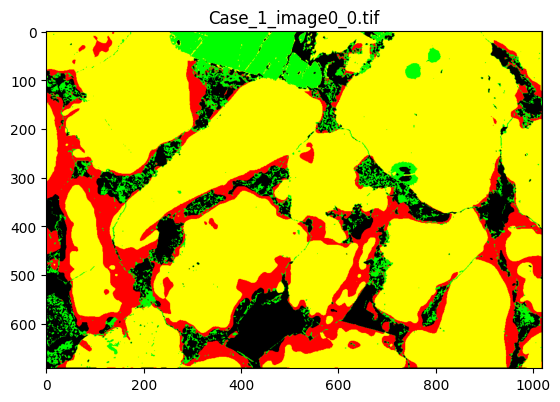

For Case 1:  {'path': ['image0_0.tif'], 'quartz_rel_area': [0.6453666464345074], 'overgrowth_rel_area': [0.13882475735590258], 'otherminerals_rel_area': [0.08585006268187671], 'pores_rel_area': [0.12995853352771333]}
For Case 2:  {'path': ['image0_0.tif'], 'quartz_rel_area': [0.6453666464345074], 'quartz_overgrowth_rel_area': [0.13882475735590258], 'otherminerals_rel_area': [0.03652282925002978], 'pores_rel_area': [0.15025781821688497], 'feldspar_rel_area': [0.02780692847458973], 'feldspar_overgrowth_rel_area': [0.001221020268085565]}
 
image0_0.tif done!


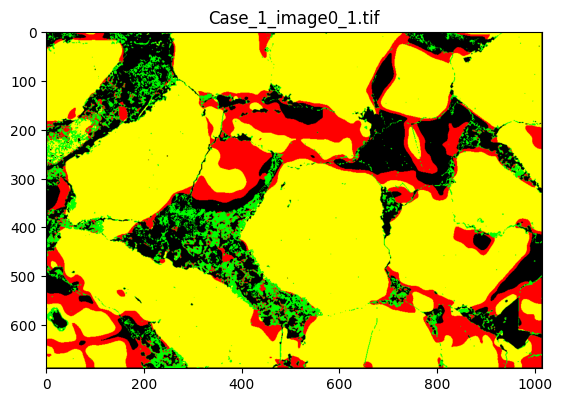

For Case 1:  {'path': ['image0_0.tif', 'image0_1.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655], 'overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577], 'otherminerals_rel_area': [0.08585006268187671, 0.07047044101345097], 'pores_rel_area': [0.12995853352771333, 0.15994737323291772]}
For Case 2:  {'path': ['image0_0.tif', 'image0_1.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655], 'quartz_overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577], 'otherminerals_rel_area': [0.03652282925002978, 0.04086717026844794], 'pores_rel_area': [0.15025781821688497, 0.18322228952150213], 'feldspar_rel_area': [0.02780692847458973, 0.006328354456418637], 'feldspar_overgrowth_rel_area': [0.001221020268085565, 0.0]}
 
image0_1.tif done!


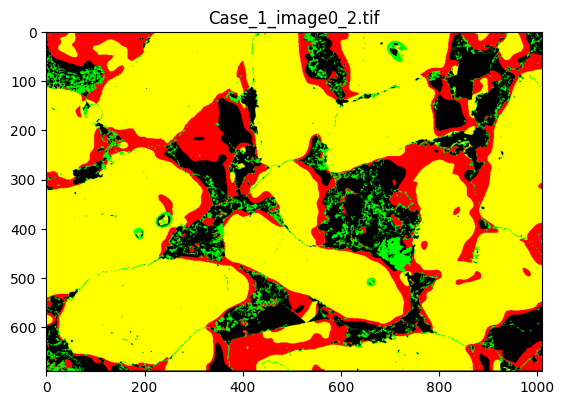

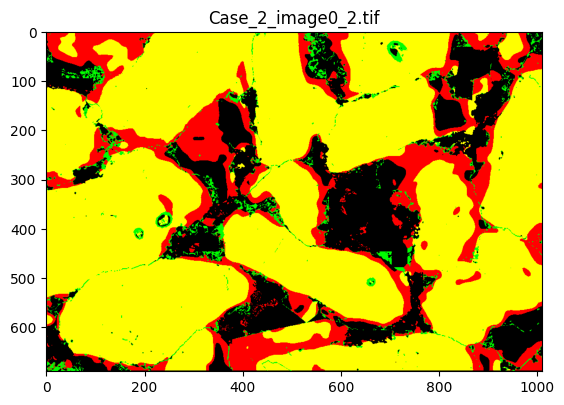

For Case 1:  {'path': ['image0_0.tif', 'image0_1.tif', 'image0_2.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655, 0.6272900517258673], 'overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577, 0.15639122522961413], 'otherminerals_rel_area': [0.08585006268187671, 0.07047044101345097, 0.054247682365921104], 'pores_rel_area': [0.12995853352771333, 0.15994737323291772, 0.16207104067859754]}
For Case 2:  {'path': ['image0_0.tif', 'image0_1.tif', 'image0_2.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655, 0.6272900517258673], 'quartz_overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577, 0.15639122522961413], 'otherminerals_rel_area': [0.03652282925002978, 0.04086717026844794, 0.031077072975025433], 'pores_rel_area': [0.15025781821688497, 0.18322228952150213, 0.1852416500694932], 'feldspar_rel_area': [0.02780692847458973, 0.006328354456418637, 0.0], 'feldspar_overgrowth_rel_area': [0.001221020268085565, 0.0, 0.0]}
 
image0_2.tif done!


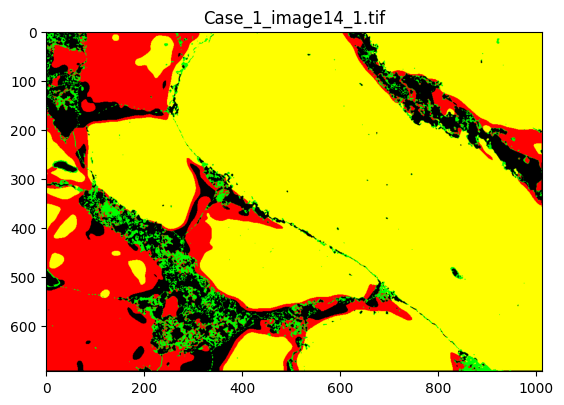

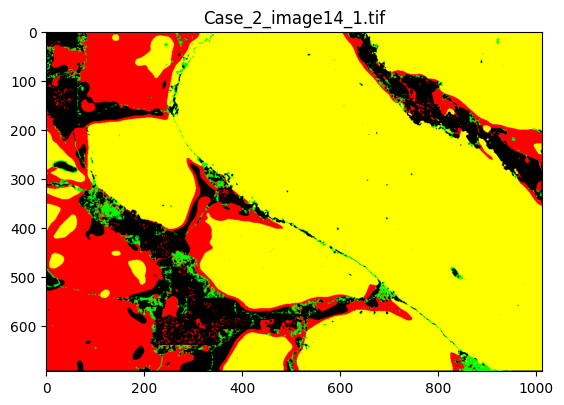

For Case 1:  {'path': ['image0_0.tif', 'image0_1.tif', 'image0_2.tif', 'image14_1.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655, 0.6272900517258673, 0.6621351858506008], 'overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577, 0.15639122522961413, 0.18524174551842537], 'otherminerals_rel_area': [0.08585006268187671, 0.07047044101345097, 0.054247682365921104, 0.04599495805029402], 'pores_rel_area': [0.12995853352771333, 0.15994737323291772, 0.16207104067859754, 0.10662811058067975]}
For Case 2:  {'path': ['image0_0.tif', 'image0_1.tif', 'image0_2.tif', 'image14_1.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655, 0.6272900517258673, 0.6621351858506008], 'quartz_overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577, 0.15639122522961413, 0.18524174551842537], 'otherminerals_rel_area': [0.03652282925002978, 0.04086717026844794, 0.031077072975025433, 0.02605102407473949], 'pores_rel_area': [0.15025781821688497, 0.18322228952150213, 0.18

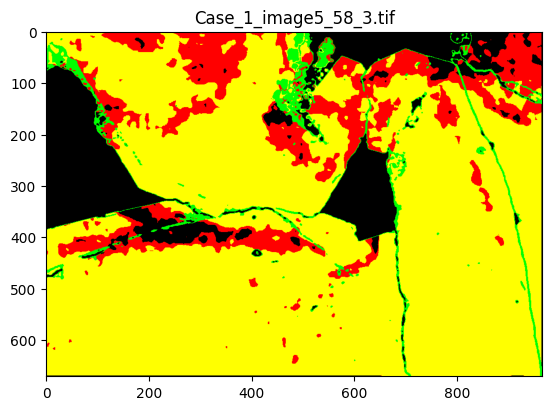

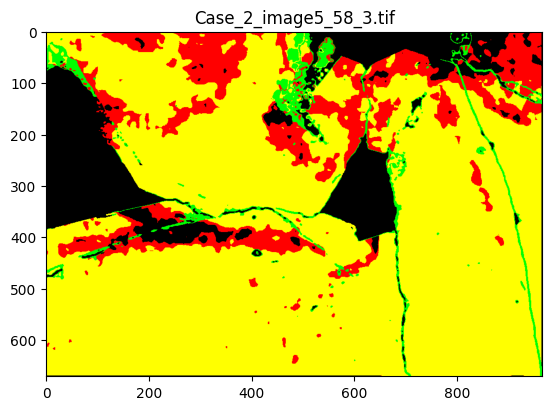

For Case 1:  {'path': ['image0_0.tif', 'image0_1.tif', 'image0_2.tif', 'image14_1.tif', 'image5_58_3.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655, 0.6272900517258673, 0.6621351858506008, 0.6851258743632229], 'overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577, 0.15639122522961413, 0.18524174551842537, 0.12968191229060794], 'otherminerals_rel_area': [0.08585006268187671, 0.07047044101345097, 0.054247682365921104, 0.04599495805029402, 0.03919091125078295], 'pores_rel_area': [0.12995853352771333, 0.15994737323291772, 0.16207104067859754, 0.10662811058067975, 0.1460013020953862]}
For Case 2:  {'path': ['image0_0.tif', 'image0_1.tif', 'image0_2.tif', 'image14_1.tif', 'image5_58_3.tif'], 'quartz_rel_area': [0.6453666464345074, 0.6376095676719655, 0.6272900517258673, 0.6621351858506008, 0.6851258743632229], 'quartz_overgrowth_rel_area': [0.13882475735590258, 0.13197261808166577, 0.15639122522961413, 0.18524174551842537, 0.12968191229060794], 'otherminerals_re

In [56]:
calculation(path_dataset)
original_flip(path_dataset)